# Example of using the PyRadiomics toolbox in Python

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

1. this notebook should be used in autorad enviroment due to radiomics version

In [1]:
from __future__ import print_function
import six
import os  # needed navigate the system to get the input data

import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics
import pandas as pd

/home/peng/opt/anaconda3/envs/autorad/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Setting up data

Test cases can be downloaded to temporary files. This is handled by the `radiomics.getTestCase()` function, which checks if the requested test case is available and if not, downloads it. It returns a tuple with the location of the image and mask of the requested test case, or (None, None) if it fails.

Alternatively, if the data is available somewhere locally, this directory can be passed as a second argument to `radiomics.getTestCase()`. If that directory does not exist or does not contain the testcase, functionality reverts to default and tries to download the test data.

If getting the test case fails, PyRadiomics will log an error explaining the cause.

In [2]:
WorkingDirectory = os.path.abspath("/home/peng/01_data/02_radiomics/SCLC-Gouhua")
ResultDirectory = os.path.join(WorkingDirectory, "result")


In [5]:
# Get the testCase
imagePath = os.path.join(ResultDirectory, "10-2-1", "10-2-1.nii.gz")
maskPath = os.path.join(ResultDirectory, "10-2-1", "10-2-1_roi.nii.gz")

if imagePath is None or maskPath is None:  # Something went wrong, in this case PyRadiomics will also log an error
    raise Exception('Error getting testcase!')  # Raise exception to prevent cells below from running in case of "run all"

# Additonally, store the location of the example parameter file, stored in \pyradiomics\examples/exampleSettings
paramPath = os.path.join(os.getcwd(), 'pyradiomics_params', 'CT-extractor.yaml')
print('Parameter file, absolute path:', os.path.abspath(paramPath))

Parameter file, absolute path: /home/peng/00_github/03_radiomics/240609_Radiomics-research-by-using-Python_SP/pyradiomics/pyradiomics_params/CT-extractor.yaml


In [6]:

import SimpleITK as sitk

image = sitk.ReadImage(imagePath)
mask = sitk.ReadImage(maskPath)

image_array=sitk.GetArrayFromImage(image)[:,:,:]

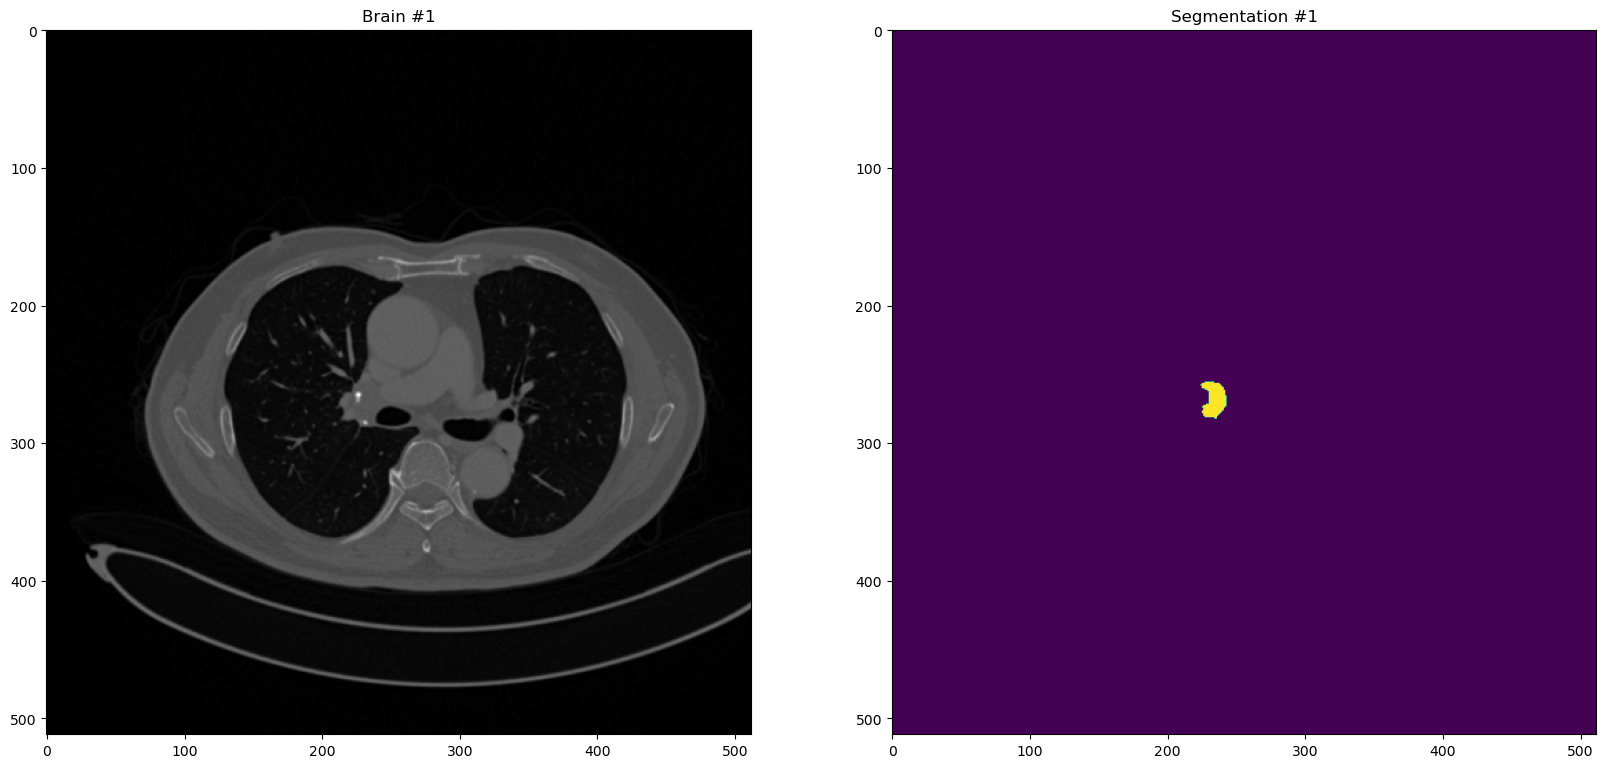

In [7]:
# Display and check the images
%matplotlib inline
import matplotlib.pyplot as plt
slice_no = 277
plt.figure(figsize=(20,20))
# First image
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image)[slice_no,:,:], cmap="gray")
plt.title("Brain #1")
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(mask)[slice_no,:,:])        
plt.title("Segmentation #1")

plt.show()

### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are three possibilities:

1. Use defaults, don't define custom settings

2. Define parameters in a dictionary, control filters and features after initialisation

3. Use a parameter file

##### Method 3, using a parameter file

In [8]:
# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': [1, 1, 1], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 10, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 1000}
Enabled filters:
	 {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}, 'Wavelet': {}, 'Square': {}, 'SquareRoot': {}, 'Logarithm': {}, 'Exponential': {}}
Enabled features:
	 {'shape': None, 'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'glrlm': None, 'glszm': None, 'gldm': 

### Extract features

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [9]:
result = extractor.execute(imagePath, maskPath)
# print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
# print('')
# print('Calculated features')
# for key, value in six.iteritems(result):
#     print('\t', key, ':', value)
df_test = pd.DataFrame.from_dict(result.values()).T
df_test.columns = result.keys()
df_test.to_excel(WorkingDirectory + '/' + 'results_test.xlsx')

In [10]:
df = pd.DataFrame()
for root,dirs,files in os.walk(ResultDirectory):
        if dirs:
            # print(dirs)
            for dir in dirs:
                for subroot,subdirs,subfiles in os.walk(root + '/'+ dir):
                    # maskName = subroot + '/' + "CT1.nii"
                    maskName =  dir + "_roi.nii.gz"
                    imageName = dir + ".nii.gz"
                    maskPath = subroot + '/' + maskName
                    print(maskName)
                    # print(dir)
                    print(subroot)
                    print(subdirs)
                    print(subfiles)
                    df_temp = pd.DataFrame()
                    for file in subfiles:
                        if file == "adc_Reg.nii" or file == "max_b_dwi_Reg.nii" or file == "CT_0000.nii.gz" or file == imageName:
                            imagePath = subroot + '/' + file
                            print(imagePath)
                            featureVector = extractor.executes(imagePath,maskPath)
                            df_add = pd.DataFrame.from_dict(featureVector.values()).T
                            df_add.columns = featureVector.keys()
                            df_temp = pd.concat([df_temp, df_add],axis=1)
                            df_temp = df_temp.drop(df_temp.columns[0], axis=1)       
                            df_temp.insert(0,'Sub',dir)
                            print(df_temp)
                        else:
                            continue
                df = pd.concat([df, df_temp],axis=0)
        else:
            continue


49-1_roi.nii.gz
/home/peng/01_data/02_radiomics/SCLC-Gouhua/result/49-1
[]
['49-1_roi.nii.gz', '49-1.nii.gz']
/home/peng/01_data/02_radiomics/SCLC-Gouhua/result/49-1/49-1.nii.gz
    Sub diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0  49-1                     1.26.4                        2.1.1.2   

  diagnostics_Versions_PyWavelet diagnostics_Versions_Python  \
0                          1.6.0                     3.10.14   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   

         diagnostics_Configuration_EnabledImageTypes  \
0  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   

            diagnostics_Image-original_Hash  \
0  a1d8f21b2c1f3108d153851d538c7418b82937ed   

  diagnostics_Image-original_Dimensionality  \
0                                        3D   

  diagnostics_Image-original_Spacing  ...  \
0      (0.67578125, 0.67578125, 2.0)  ...   

  exponential_gldm_LargeDependenceLowGrayLevelE

In [11]:
df.to_excel(WorkingDirectory + '/' + 'results.xlsx')